In [1]:
import xgboost as xgb
# import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

In [2]:
# Read in data and split data to be used in the models
titanic = pd.read_csv('cleaned_titanic.csv', index_col='PassengerId')

In [3]:
# Create matrix of features
X = titanic.drop('Survived', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = titanic['Survived'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

In [4]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)


# XGBoost's hyperparameters

At this point, before building the model, you should be aware of the tuning parameters that XGBoost provides. Well, there are a plethora of tuning parameters for tree-based learners in XGBoost and you can read all about them [here](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters). But the most common ones that you should know are:

- **learning_rate**: step size shrinkage used to prevent overfitting. Range is [0,1]
- **max_depth**: determines how deeply each tree is allowed to grow during any boosting round.
- **subsample**: percentage of samples used per tree. Low value can lead to underfitting.
- **colsample_bytree**: percentage of features used per tree. High value can lead to overfitting.
- **n_estimators**: number of trees you want to build.
- **objective**: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

- **gamma**: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- **alpha**: L1 regularization on leaf weights. A large value leads to more regularization.
- **lambda**: L2 regularization on leaf weights and is smoother than L1 regularization.

In [5]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 2, alpha = 10, n_estimators = 100)

In [6]:
xg_clf.fit(X_train,y_train)


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [7]:
preds = xg_clf.predict(X_test)


test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.807175
F1: 0.711409


# k-fold Cross Validation using XGBoost
In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. XGBoost supports k-fold cross validation via the cv() method. All you have to do is specify the nfolds parameter, which is the number of cross validation sets you want to build. Also, it supports many other parameters (check out this link) like:

- **num_boost_round**: denotes the number of trees you build (analogous to n_estimators)
- **metrics:** tells the evaluation metrics to be watched during CV
- **as_pandas**: to return the results in a pandas DataFrame.
- **early_stopping_rounds: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.
- **seed**: for reproducibility of results.

Before running your model, you will convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains. 

In [8]:
data_dmatrix = xgb.DMatrix(data=X,label=y)



C:\Users\dlm66\Anaconda3\lib\site-packages\xgboost-0.83.dev0-py3.7.egg\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dlm66\Anaconda3\lib\site-packages\xgboost-0.83.dev0-py3.7.egg\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [9]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 2, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=5,metrics="logloss", as_pandas=True, seed=123)
cv_results 

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.663809,0.000768,0.664432,0.001201
1,0.649386,0.007769,0.650293,0.009091
2,0.639790,0.008282,0.641551,0.009498
3,0.630923,0.011054,0.632822,0.010948
4,0.627469,0.011194,0.629472,0.011235
5,0.614946,0.011402,0.617066,0.013344
6,0.612587,0.011340,0.614983,0.013672
7,0.609946,0.011559,0.612319,0.013900
8,0.603315,0.010589,0.606532,0.012787
9,0.597327,0.012510,0.601291,0.015202


In [10]:
xg_clf = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

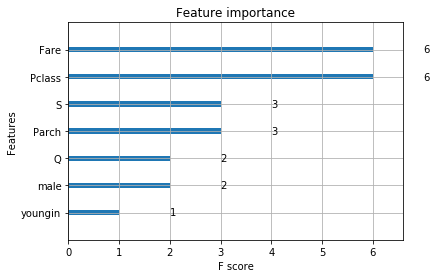

In [12]:
xgb.plot_importance(xg_clf)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [ ]:
    xgboost_model.

In [13]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))

    return alg
#     feat_imp = pd.Series(alg.get_booster().get_fscore())
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')fp

In [14]:
train  = pd.concat([X_train, y_train], axis=1)
target = 'Survived'
IDcol = 'PassengerId'

In [15]:
train.head()

,Pclass,Age,SibSp,Parch,Fare,youngin,male,Q,S,Survived
PassengerId,,,,,,,,,,
740,3,24.0,0,0,7.8958,0,1,0,1,0
148,3,9.0,2,2,34.3750,1,0,0,1,0
876,3,15.0,0,0,7.2250,0,0,0,0,1
641,3,20.0,0,0,7.8542,0,1,0,1,0
885,3,25.0,0,0,7.0500,0,1,0,1,0


In [16]:
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [17]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=3,
 scale_pos_weight=1,
 seed=27)

alg = modelfit(xgb1, train, predictors, target)


Model Report
Accuracy : 0.9249
AUC Score (Train): 0.977097


In [18]:
alg.feature_importances_

array([0.11450761, 0.04253057, 0.07107796, 0.04770331, 0.04796214,
       0.0582455 , 0.5413605 , 0.03617661, 0.04043587], dtype=float32)

In [19]:
from sklearn.model_selection import GridSearchCV

In [21]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\Users\dlm66\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\dlm66\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\dlm66\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\dlm66\Anaconda3\lib\site-packages\sklearn\util

({'mean_fit_time': array([0.3087225 , 0.2800467 , 0.26367683, 0.40384126, 0.38894134,
         0.36493707, 0.52192445, 0.45475612, 0.40468955, 0.58838339,
         0.48034921, 0.37024202]),
  'std_fit_time': array([0.01580152, 0.00586575, 0.01542302, 0.01430271, 0.00277315,
         0.00914169, 0.00658206, 0.00709667, 0.00386855, 0.0076109 ,
         0.01188978, 0.03336647]),
  'mean_score_time': array([0.00992365, 0.01329327, 0.0066278 , 0.00735869, 0.00312428,
         0.00624919, 0.00342946, 0.00648584, 0.0066062 , 0.00626788,
         0.00542722, 0.00533681]),
  'std_score_time': array([0.00811456, 0.00668963, 0.00623439, 0.00823025, 0.00624857,
         0.00765366, 0.00637017, 0.00777847, 0.0080958 , 0.00767662,
         0.00581948, 0.00594705]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

In [31]:
gsearch1.best_params_

{'max_depth': 9, 'min_child_weight': 3}

In [32]:
gsearch1.best_score_

0.8843934222078875

In [33]:
preds = gsearch1.best_estimator_.predict(X_test)


test_f1 = f1_score(y_test, preds)
test_acc = accuracy_score(y_test, preds)

print("Accuracy: %f" % (test_acc))
print("F1: %f" % (test_f1))

Accuracy: 0.784753
F1: 0.671233


In [34]:

# plot feature importance
plot_importance(alg)
pyplot.show()

NameError: name 'plot_importance' is not defined

In [ ]:
from xgboost import plot_importance

In [ ]:
alg.get_booster().get_fscore()

## Saving a Model

In [24]:
import pickle

In [40]:
# pickle list object
 
model_pickle_path = 'xg_boost_model.pkl'

# Create an variable to pickle and open it in write mode
model_pickle = open(model_pickle_path, 'wb')
pickle.dump(gsearch1, model_pickle)
model_pickle.close()

In [41]:
# Loading the saved XGboost model pickle
xgboost_model_pkl = open(model_pickle_path, 'rb')
xgboost_model = pickle.load(xgboost_model_pkl)
print("Loaded XGboost model :: ", xgboost_model)


Loaded XGboost model ::  GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, n_estimators=140, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


In [42]:
xgboost_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=3, missing=nan, n_estimators=140, n_jobs=1,
       nthread=4, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=None,
       subsample=0.8, verbosity=1)

In [ ]:
xg